<a href="https://colab.research.google.com/github/yousuke0614/hangman/blob/master/ajisaiCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **紫陽花 種別判定 CNN**
・機械学習用ライブラリ：Pytorch

・プログラミング言語：Python

・学習用データ：「花の手帖」【紫陽花図鑑】に掲載されている紫陽花の画像を1種類につき2～3枚、計10種類使用（データ総数：6,600枚）

**【概要】**
10クラス認識のCNNモデルを設計し学習させる

**【目次】**

1. データの準備
1. モデルの定義
1. モデルの学習
1. 学習記録のグラフ化
1. モデルのセーブ・ロード
1. モデルを用いたクラス認識予測

# 1.1 ライブラリのインポート

In [0]:
import os
import time
import copy

import torch as torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
from tqdm import tqdm_notebook
from torchsummary import summary
from pylab import rcParams

# 1.2 前処理

**【transfoms】**

・transforms.Compose：オブジェクトをまとめて返す 

・transforms.ToTensor()： PILImage -> Tensor, 0~1正規化  

pytorchではデータをTensor形式で扱う

In [0]:
transform_dict = {
        'train':transforms.Compose(
            [transforms.Resize((32,32)),
             transforms.ToTensor(),
             transforms.Normalize((0.5,), (0.5,)),
             ]),
        'test': transforms.Compose(
             [transforms.Resize((32,32)),
             transforms.ToTensor(),
             transforms.Normalize((0.5,), (0.5,)),
             ])}

# 1.3 データセット作成

torchvision.datasets.ImageFolder：ディレクトリからデータセットを作成（ディレクトリ毎に自動でラベル付けを行う）

In [0]:
data_folder = "/content/drive/My Drive/ajisai"

data = torchvision.datasets.ImageFolder(root=data_folder, transform=transform_dict["train"])

# 1.4 データセットを訓練用とテスト用に分割

torch.utils.data.random_split(dataset, lengths)：データセットをランダムに分割

In [4]:
train_ratio = 0.8

train_size = int(train_ratio * len(data))
test_size  = len(data) - train_size      

print(train_size)
print(test_size)
data_train, data_test = torch.utils.data.random_split(data, [train_size, test_size])

5280
1320


# 1.5 データセット可視化する関数を定義

・データセットの入力画像（PILImage）をtorchvision.transforms.ToTensor()でTensor型に変換したものを出力

・np.transpose：（C,H,W）を画像を表示するplt.imshow関数の引数の入力画像サイズ（H,W,C）に変換

In [0]:
%matplotlib inline
def show(img):
    npimg = img.numpy() 
    plt.grid(False) 
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

# 1.6 データセットの可視化

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


学習画像サイズ： torch.Size([3, 32, 32])
ラベル： 4


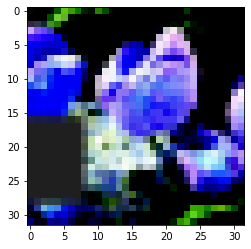

In [6]:
image, label = data_train[1]
print("学習画像サイズ：",image.size())
print ("ラベル：",label)
show(image)

# 1.7 データセットをミニバッチ単位に変換

・torch.utils.data.DataLoader：

In [0]:
train_loader = torch.utils.data.DataLoader(data_train, batch_size=64, shuffle=True,  num_workers=4)
test_loader   = torch.utils.data.DataLoader(data_test,   batch_size=64, shuffle=False, num_workers=4)

In [0]:
torch.cuda.empty_cache()

# 2.1. モデルの定義(nn.Moduleを継承したクラス)

・__init__関数：ネットワーク層の定義、初期化を行う

・forward関数：モデルの入力 ⇒ 出力の定義、順伝搬の計算を行う（定義したネットワーク層に入力(x)を伝搬していく）

・全結合ネットワーク：nn.Liner(入力パラメータ数、出力パラメータ数)で定義する

※画像データを扱う場合、入力パラメータ数は二次元データを一次元に変換して入力する

※Tensorのサイズ変換にはTensor.view(軸について要素数を指定)を用いる

In [0]:
num_classes = 10 #出力クラス数

class AlexNet(nn.Module):

    #畳み込みブロック(プーリングなし)
    def conv_block(self, in_dim, out_dim):
        return nn.Sequential(
            nn.Conv2d(in_dim, out_dim, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_dim),
            nn.ReLU(inplace=True),
        )

    #畳み込みブロック(プーリングあり)
    def conv_block_pooling(self, in_dim, out_dim):
        return nn.Sequential(
            nn.Conv2d(in_dim, out_dim, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_dim),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
        )

    def __init__(self, num_classes):
        super(AlexNet, self).__init__()
        #畳み込みブロック群
        self.block1=self.conv_block(3,96)
        self.block2=self.conv_block_pooling(96,256)
        self.block3=self.conv_block(256,384)
        self.block4=self.conv_block_pooling(384,384)
        self.block5=self.conv_block(384,256)
        #全結合ブロック群
        self.classifier= nn.Sequential(
            #6ブロック(ここから全結合層)
            nn.Dropout(p=0.5),
            nn.Linear(256*8*8,1048),
            #7ブロック
            nn.Dropout(p=0.5),
            nn.Linear(1048,1048),
            #8ブロック(出力)
            nn.Linear(1048,num_classes),
        )

    def forward(self, x):
        #1-5ブロック
        x=self.block1(x)
        x=self.block2(x)
        x=self.block3(x)
        x=self.block4(x)
        x=self.block5(x)
        #(N,C,H,W)→(N,C*H*W)
        x = x.view(x.size(0),256*8*8)
        #6-8ブロック
        x = self.classifier(x)
        return x
    

device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = AlexNet(num_classes).to(device)#モデルをインスタンス

# 2.2 モデルの可視化

・summary(モデル,入力サイズ(チャンネル数、パラメータ数))：クラスで可視化を行う

In [11]:
summary(net, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 32, 32]           2,688
       BatchNorm2d-2           [-1, 96, 32, 32]             192
              ReLU-3           [-1, 96, 32, 32]               0
            Conv2d-4          [-1, 256, 32, 32]         221,440
       BatchNorm2d-5          [-1, 256, 32, 32]             512
              ReLU-6          [-1, 256, 32, 32]               0
         MaxPool2d-7          [-1, 256, 16, 16]               0
            Conv2d-8          [-1, 384, 16, 16]         885,120
       BatchNorm2d-9          [-1, 384, 16, 16]             768
             ReLU-10          [-1, 384, 16, 16]               0
           Conv2d-11          [-1, 384, 16, 16]       1,327,488
      BatchNorm2d-12          [-1, 384, 16, 16]             768
             ReLU-13          [-1, 384, 16, 16]               0
        MaxPool2d-14            [-1, 38

# 3.1 モデルの学習

**【損失関数・最適化法（オプティマイザー）の定義】**

・損失関数：nn.CrossEntropyLoss()（ソフトマックス＋交差エントロピー）を用いる

・最適化法：optim.SGD(適用するモデルの重み、その他ハイパーパラメータの設定・・・)を用いる

In [0]:
criterion = nn.CrossEntropyLoss().cuda()

optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

# 3.2. 学習の流れ（エポック単位）

① 画像データと正解ラベルを取り出す

　 tqdm：jupyter内にプログレスバー（進行度）を表示

② 画像データとラベルデータ（共にバッチ単位）をデバイス（GPU）に移動

③ 勾配の初期化

④ モデルの推測（画像データ → 各クラスである確率）

⑤ 損失の計算

⑥ ⑤で求めた損失をエポックでの累計損失に加える

　 ※Tensorから値を取得する場合、1次元(1要素)に指定してから.item()で取得

⑦ 正答率の計算

　 （出力の最大値のインデックスが正解ラベルの場合1を出力をバッチサイズ分行う(.sum()）

　 （.maxは()で比較する値の軸を選び、[0]に最大値の値、[1]に最大値のインデックスを持つ）

⑧ 逆伝搬の計算

⑨ 勾配の更新

---全バッチで行う---

⑩ エポックでの平均誤差の計算

⑪ エポックでの平均正答率の計算

検証データでの損失、精度を学習時と同じアルゴリズムで検証（逆伝搬、勾配の更新は行わない）

*1:学習時には.train()で学習に関連する機能を有効にする   
*2:検証時には.eval()で学習に関連する機能を有効に、torch.no_grad()で自動微分を停止してから検証を行う

In [13]:
num_epochs = 20 #学習エポックの設定

#グラフ作成のためにエポックごとの各値を保存する配列を作成
train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

#学習の定義
for epoch in range(num_epochs):
    train_loss = 0
    train_acc = 0
    val_loss = 0
    val_acc = 0
    i=0#学習回数

    net.train() #train *1
    for (images, labels) in tqdm_notebook(train_loader): #①
        images, labels = images.to(device), labels.to(device) #②
        optimizer.zero_grad() #③
        outputs = net(images) #④
        loss = criterion(outputs, labels)#⑤
        train_loss += loss.item()#⑥
        train_acc += (outputs.max(1)[1] == labels).sum().item() #⑦
        loss.backward()#⑧
        optimizer.step()#⑨

    avg_train_loss = train_loss / len(train_loader.dataset) #⑩
    avg_train_acc = train_acc / len(train_loader.dataset)   #⑪

    net.eval() #val *2
    with torch.no_grad():#自動微分停止 *2
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = net(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            val_acc += (outputs.max(1)[1] == labels).sum().item()
        avg_val_loss = val_loss / len(test_loader.dataset)
        avg_val_acc = val_acc / len(test_loader.dataset)

        print ('Epoch [{}/{}], Loss: {loss:.4f}, val_loss: {val_loss:.4f}, val_acc: {val_acc:.4f}' 
                   .format(epoch+1, num_epochs, i+1, loss=avg_train_loss, val_loss=avg_val_loss, val_acc=avg_val_acc))
        
        #グラフ壁画用に各値を配列に格納
        train_loss_list.append(avg_train_loss)
        train_acc_list.append(avg_train_acc)
        val_loss_list.append(avg_val_loss)
        val_acc_list.append(avg_val_acc)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch [1/20], Loss: 0.0042, val_loss: 0.0000, val_acc: 1.0000



Epoch [2/20], Loss: 0.0000, val_loss: 0.0000, val_acc: 1.0000



Epoch [3/20], Loss: 0.0000, val_loss: 0.0000, val_acc: 1.0000



Epoch [4/20], Loss: 0.0000, val_loss: 0.0000, val_acc: 1.0000



Epoch [5/20], Loss: 0.0000, val_loss: 0.0000, val_acc: 1.0000



Epoch [6/20], Loss: 0.0000, val_loss: 0.0000, val_acc: 1.0000



Epoch [7/20], Loss: 0.0000, val_loss: 0.0000, val_acc: 1.0000



Epoch [8/20], Loss: 0.0000, val_loss: 0.0000, val_acc: 1.0000



Epoch [9/20], Loss: 0.0000, val_loss: 0.0000, val_acc: 1.0000



Epoch [10/20], Loss: 0.0000, val_loss: 0.0000, val_acc: 1.0000



Epoch [11/20], Loss: 0.0000, val_loss: 0.0000, val_acc: 1.0000



Epoch [12/20], Loss: 0.0000, val_loss: 0.0000, val_acc: 1.0000



Epoch [13/20], Loss: 0.0000, val_loss: 0.0000, val_acc: 1.0000



Epoch [14/20], Loss: 0.0000, val_loss: 0.0000, val_acc: 1.0000



Epoch [15/20], Loss: 0.0000, val_loss: 0.0000, val_acc: 1.0000



Epoch [16/20], Loss: 0.0000, val_loss: 0.0000, val_acc: 1.0000



Epoch [17/20], Loss: 0.0000, val_loss: 0.0000, val_acc: 1.0000



Epoch [18/20], Loss: 0.0000, val_loss: 0.0000, val_acc: 1.0000



Epoch [19/20], Loss: 0.0000, val_loss: 0.0000, val_acc: 1.0000



Epoch [20/20], Loss: 0.0000, val_loss: 0.0000, val_acc: 1.0000


# 4. 学習記録のグラフ化

matplotlib：

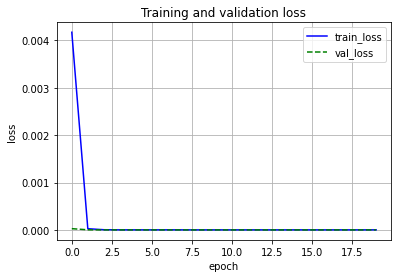

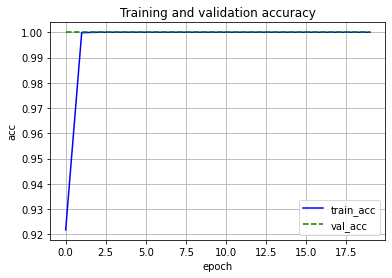

In [14]:
#学習のグラフ化
plt.figure()
plt.plot(range(num_epochs), train_loss_list, color='blue', linestyle='-', label='train_loss')
plt.plot(range(num_epochs), val_loss_list, color='green', linestyle='--', label='val_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and validation loss')
plt.grid()

plt.figure()
plt.plot(range(num_epochs), train_acc_list, color='blue', linestyle='-', label='train_acc')
plt.plot(range(num_epochs), val_acc_list, color='green', linestyle='--', label='val_acc')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.title('Training and validation accuracy')
plt.grid()

# 5.1 モデルのセーブ

In [0]:
torch.save(net.state_dict(),"net.ckpt") # モデルの保存

# 5.2 モデルのロード

In [16]:
#学習済みモデルを使用する場合はモデルをロード
net.load_state_dict(torch.load("net.ckpt"))

<All keys matched successfully>

# 6. モデルを用いたクラス認識予測

① データ[藍姫]：確率0.1175 → 予測[綾波]：確率0.3270（**不正解**）

② データ[茜月]：確率0.3048 → 予測[青覆輪清澄沢]：確率0.3587（**不正解**）

③ データ[アリガトウ]：確率0.9033（**正解**）

④ データ[アナベル]：確率0.8525（**正解**）

**※一見して他の種別と特徴が大きく異なる種別の正解率は高いが、他の複数の種別と似ている特徴がある種別の正解率は低い**

torch.Size([1, 3, 32, 32])


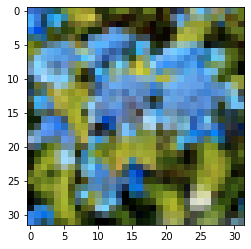

In [27]:
image_path = "/content/test_aihime.jpg"
img = Image.open(image_path)
img = img.resize((32, 32))
plt.imshow(img)
img=transforms.ToTensor()(img)
img=img.unsqueeze(0)
print(img.shape)

In [28]:
net.eval()
with torch.no_grad():
    output=net(img.cuda())
    output=output.cpu()
    label_name=["aihime","aofukurinkiyosumisawa","akanezuki","asianbeauty","atsumishibori","annabelle","amacha","ameniutaeba","ayanami","arigatou"] 
    output_probability=nn.Softmax(0)(output[0])
    for i in range(0,10):
        print(label_name[i],"である確率は",output_probability[i].item(),"です")
    predict_label=output.max(1)[1]
    print("入力した画像のクラスは",label_name[predict_label.item()],"です")

aihime である確率は 0.11756069958209991 です
aofukurinkiyosumisawa である確率は 0.23822656273841858 です
akanezuki である確率は 0.0019596205092966557 です
asianbeauty である確率は 0.000335988326696679 です
atsumishibori である確率は 0.06249390169978142 です
annabelle である確率は 0.029190562665462494 です
amacha である確率は 1.9081018763245083e-05 です
ameniutaeba である確率は 0.005299353506416082 です
ayanami である確率は 0.3270767629146576 です
arigatou である確率は 0.21783745288848877 です
入力した画像のクラスは ayanami です


torch.Size([1, 3, 32, 32])


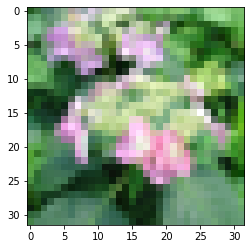

In [29]:
image_path = "/content/test_akanezuki.jpg"
img = Image.open(image_path)
img = img.resize((32, 32))
plt.imshow(img)
img=transforms.ToTensor()(img)
img=img.unsqueeze(0)
print(img.shape)

In [30]:
net.eval()
with torch.no_grad():
    output=net(img.cuda())
    output=output.cpu()
    label_name=["aihime","aofukurinkiyosumisawa","akanezuki","asianbeauty","atsumishibori","annabelle","amacha","ameniutaeba","ayanami","arigatou"] 
    output_probability=nn.Softmax(0)(output[0])
    for i in range(0,10):
        print(label_name[i],"である確率は",output_probability[i].item(),"です")
    predict_label=output.max(1)[1]
    print("入力した画像のクラスは",label_name[predict_label.item()],"です")

aihime である確率は 0.007171363104134798 です
aofukurinkiyosumisawa である確率は 0.358701229095459 です
akanezuki である確率は 0.3048841059207916 です
asianbeauty である確率は 0.0010479046031832695 です
atsumishibori である確率は 0.0032386041712015867 です
annabelle である確率は 0.0008403324754908681 です
amacha である確率は 8.417770004598424e-05 です
ameniutaeba である確率は 0.010047686286270618 です
ayanami である確率は 0.05262535810470581 です
arigatou である確率は 0.2613592743873596 です
入力した画像のクラスは aofukurinkiyosumisawa です


torch.Size([1, 3, 32, 32])


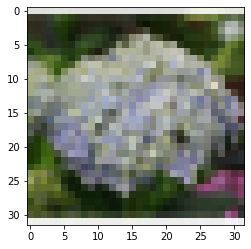

In [33]:
image_path = "/content/test_arigatou.jpg"
img = Image.open(image_path)
img = img.resize((32, 32))
plt.imshow(img)
img=transforms.ToTensor()(img)
img=img.unsqueeze(0)
print(img.shape)

In [34]:
net.eval()
with torch.no_grad():
    output=net(img.cuda())
    output=output.cpu()
    label_name=["aihime","aofukurinkiyosumisawa","akanezuki","asianbeauty","atsumishibori","annabelle","amacha","ameniutaeba","ayanami","arigatou"] 
    output_probability=nn.Softmax(0)(output[0])
    for i in range(0,10):
        print(label_name[i],"である確率は",output_probability[i].item(),"です")
    predict_label=output.max(1)[1]
    print("入力した画像のクラスは",label_name[predict_label.item()],"です")

aihime である確率は 6.160367775009945e-05 です
aofukurinkiyosumisawa である確率は 0.02062094584107399 です
akanezuki である確率は 0.0001997811923502013 です
asianbeauty である確率は 0.00018443784210830927 です
atsumishibori である確率は 0.0012240668293088675 です
annabelle である確率は 0.06550619006156921 です
amacha である確率は 7.707140866841655e-06 です
ameniutaeba である確率は 0.0068444907665252686 です
ayanami である確率は 0.0020278075244277716 です
arigatou である確率は 0.9033229351043701 です
入力した画像のクラスは arigatou です


torch.Size([1, 3, 32, 32])


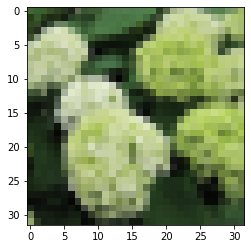

In [35]:
image_path = "/content/test_annabelle.jpg"
img = Image.open(image_path)
img = img.resize((32, 32))
plt.imshow(img)
img=transforms.ToTensor()(img)
img=img.unsqueeze(0)
print(img.shape)

In [36]:
net.eval()
with torch.no_grad():
    output=net(img.cuda())
    output=output.cpu()
    label_name=["aihime","aofukurinkiyosumisawa","akanezuki","asianbeauty","atsumishibori","annabelle","amacha","ameniutaeba","ayanami","arigatou"] 
    output_probability=nn.Softmax(0)(output[0])
    for i in range(0,10):
        print(label_name[i],"である確率は",output_probability[i].item(),"です")
    predict_label=output.max(1)[1]
    print("入力した画像のクラスは",label_name[predict_label.item()],"です")

aihime である確率は 0.015545226633548737 です
aofukurinkiyosumisawa である確率は 0.0010918917832896113 です
akanezuki である確率は 0.0008507482707500458 です
asianbeauty である確率は 0.0017774492735043168 です
atsumishibori である確率は 0.005645304452627897 です
annabelle である確率は 0.852537989616394 です
amacha である確率は 7.936631845950615e-06 です
ameniutaeba である確率は 0.003422587877139449 です
ayanami である確率は 0.10478393733501434 です
arigatou である確率は 0.014336963184177876 です
入力した画像のクラスは annabelle です
